# Self study 1

In this self study you should work on the code examples below together with the associated questions. The notebook illustrates a basic neural network implementation, where we implement most of the relevant functions from scratch, except for the calculation of the gradients, for which we rely on the functionality provided by <a urel="https://pytorch.org">PyTorch</a>. 

Since we rely on PyTorch functionality, we will also be using PyTorch's tensor data structure. This data structure operates in much the same way as numpy's ndarrays. You can find a brief introduction to PyTorch's tensors <a href="https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html">here</a>.  



The code illustrates the key concepts involved in the learning neural network. Go carefully through the code before starting to answer the questions at the end.

First we import the modules used in this selfstudy

In [2]:
import torch
from torchvision import datasets, transforms
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.nn as nn

Through torch load the MNIST data set, which we will use in this self study. The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

Using the data loader provided by torch we have an easy way of loading in data in batches (here of size 64). We can also make various other transformation of the data, such as normalization. The details for loading the data are not really that important, but if yiu are curious, you can find a quick introduction <a href="https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html">here</a>.

In [3]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In the cell above, we are loading data in batches, which is subsequently used during optimization. We didn't discuss batch based learning during the last lecture, but please take a look at Slides 24 and 25 to get the gist of the approach. We will cover it in more detail during the next lecture.   

Each batch is a list of two elements. The first element encodes the digit and has dimensions [64,1,28,28] (the figures are greyscale with no rbg channel, hence the '1'), and the second element contains the class/label information. 

Batch dimension (digit): torch.Size([64, 1, 28, 28])
Batch dimension (target): torch.Size([64])
Target: 1 with shape torch.Size([])


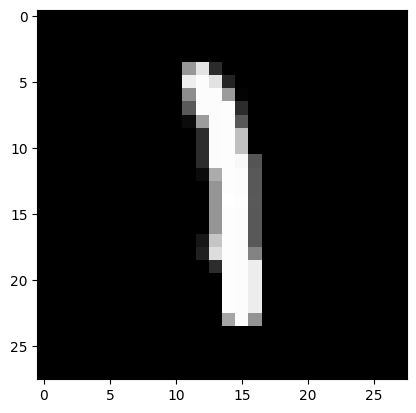

In [4]:
batch = next(iter(train_loader))
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

With PyTorch we can specify that the tensors require gradients. This will make PyTorch record all operations performed on the tensors, so that we can afterwards calculate the gradients automatically using back propagation. See also the code example from the last lecture.

For the first part of this self study we will specify a neural network, which will encode a softmax function (see, e.g., Page 180 in <a href="https://www.deeplearningbook.org/contents/mlp.html">The Deep Learning book</a>). For this we need a (randomly initialized) weight matrix and a bias, and for both of them we need their gradients wrt. our error function (yet to be defined) in order to perform learning. Note that to facilitate matrix multiplication we will flatten our image from $28\times 28$ to $784$. 

In [5]:
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

Out model specification

In [6]:
def softmax(x):
    return x.exp() / x.exp().sum(-1).unsqueeze(-1)

def model(xb):
    return softmax(xb @ weights + bias)

Let's test our model (with our randomly initialized weights)

In [7]:
# We flatten the digit representation so that it is consistent with the weight matrix
xb = digit_batch.flatten(start_dim=1)
print(f"Batch shape: {xb.shape}")
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

Batch shape: torch.Size([64, 784])
Prediction on first image tensor([0.0690, 0.0776, 0.0578, 0.2733, 0.0330, 0.0454, 0.0680, 0.1618, 0.1768,
        0.0373], grad_fn=<SelectBackward0>)
Corresponding classification: 3


Next we define our loss function, in this case the log-loss (or negative log-likelihood):

In [16]:
def nll(input, target):
    return (-input[range(target.shape[0]), target].log()).mean() 
loss_func = nll

# Make a test calculation
yb = batch[1]
print(loss_func(preds,yb))

tensor(2.6341, grad_fn=<MeanBackward0>)


In the end, we are interested in the accuracy of our model

In [9]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

In [10]:
print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Accuracy of model on batch (with random weights): 0.03125


Now we are ready to combine it all and perform learning

In [11]:
epochs = 1  # how many epochs to train for
lr = 0.01  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        # We specify the loss
        loss = loss_func(pred, yb)
        # and perform backpropagation    
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # After updating we set the gradients to zero so that we ar eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()

            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 2.5153433915648633
Epoch: 0, B-idx: 50, Training loss: 0.8358087456429691


KeyboardInterrupt: 

Plot the evolution of the training loss

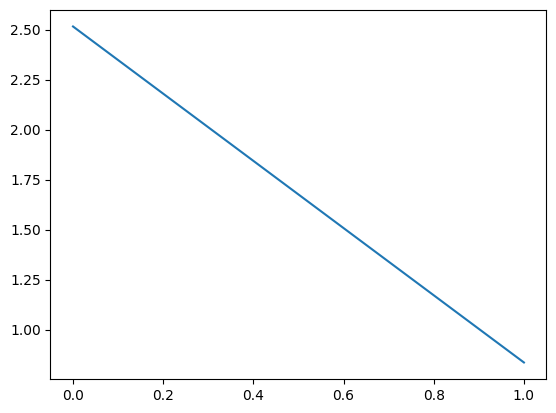

In [12]:
plt.plot(range(len(train_losses)), train_losses)

__Exercise:__ 
1. Experiment with different variations of the gradient descent implementation; try varying the learning rate and the batch size. Assuming that you have a fixed time budget (say 2 minutes for learning), what can we then say about the effect of changing the parameters?
2. Implement momentum in the learning algorithm. How does it affect the results?
3. Try with different initialization schemes for the parameters (e.g. allowing for larger values). How does it affect the behavior of the algorithm?
4. Analyze the behavior of the algorithm on the test set and implement a method for evaluating the accuracy over the entire training/test set.
5. If you feel adventorous, you are welcome to try to specify and experiment with other more advanced model architectures (cell 23). 

# Exercise 1

## Load data

In [ ]:
batch_size = 1024
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

## Train

In [ ]:
# Reset model
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

epochs = 1  # how many epochs to train for
lr = 1  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        # We specify the loss
        loss = loss_func(pred, yb)
        # and perform backpropagation    
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # After updating we set the gradients to zero so that we ar eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()

            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([loss_func(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: inf
Epoch: 0, B-idx: 50, Training loss: nan


## Evaluation

In [ ]:
xb = digit_batch.flatten(start_dim=1)
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

# Make a test calculation
yb = batch[1]
print(preds.size())
print(yb.size())
print(loss_func(preds,yb))

print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Prediction on first image tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       grad_fn=<SelectBackward0>)
Corresponding classification: 0
torch.Size([64, 10])
torch.Size([64])
tensor(nan, grad_fn=<MeanBackward0>)
Accuracy of model on batch (with random weights): 0.0625


## Notes
Learning rate:  0.1,    0.1,    0.1,    0.1,    0.01,   0.01,   0.01,   0.01
Batch size:     64,     512,    1024,   1024,   1024,   4096,   4096,   1024
Epochs:         1,      1,      1,      10,     1,      1,      18,     10
Accuracy:       0.875,  0.953,  0.953,  0.984,  0.921   0.671,  0.9375, 0.953
Time:           1:12,   0:13,   0:10,   1:46,   0:10    0:07,   2:07,   1:46

Learning rate: 1 NaN loss

# Exercise 2

In [20]:
class MomentumLoss(nn.Module):
    def __init__(self, alpha=0.9, base_loss=nn.MSELoss()):
        super(MomentumLoss, self).__init__()
        self.alpha = alpha  # Momentum factor
        self.base_loss = nll  # The underlying loss function (e.g., MSE, CrossEntropy)
        self.momentum = None  # Initialize momentum to None

    def forward(self, outputs, targets):
        """
        Computes the momentum-based loss.

        Args:
            outputs (torch.Tensor): Model outputs.
            targets (torch.Tensor): Target values.

        Returns:
            torch.Tensor: The momentum-adjusted loss.
        """
        current_loss = self.base_loss(outputs, targets)

        if self.momentum is None:
            self.momentum = current_loss.detach()  # Initialize momentum with the first loss
        else:
            self.momentum = self.alpha * self.momentum + (1 - self.alpha) * current_loss.detach()

        return current_loss + (self.momentum - current_loss.detach()) # or just return current_loss + (self.momentum - current_loss.detach()).detach() if you want to completely stop gradients from flowing through the momentum.

# Instantiate the momentum loss
momentum_loss = MomentumLoss(alpha=0.8, base_loss=nn.MSELoss())

In [21]:
batch_size = 1024
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

In [25]:
vel = torch.zeros(1, requires_grad=False)
# Reset model
weights = torch.randn(784, 10) / np.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

epochs = 10  # how many epochs to train for
lr = 0.1  # learning rate

train_losses = []
for epoch in range(epochs):

    for batch_idx, (xb, yb) in enumerate(train_loader):

        xb = xb.squeeze().flatten(start_dim=1)
        pred = model(xb)
        # We specify the loss
        loss = momentum_loss(pred, yb)
        vel = loss
        # and perform backpropagation    
        loss.backward()
        # Lastly we update the weights and bias (torch.no_grad() ensures that no gradient 
        # calculations are taking place in this part of the code)
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr

            # After updating we set the gradients to zero so that we ar eready for the next round
            weights.grad.zero_()
            bias.grad.zero_()

            if batch_idx % 50 == 0:
                with torch.no_grad():
                    train_loss = np.mean([momentum_loss(model(txb.squeeze().flatten(start_dim=1)), tyb).item() for txb, tyb in train_loader])
                    print(f"Epoch: {epoch}, B-idx: {batch_idx}, Training loss: {train_loss}")
                    train_losses.append(train_loss)

Epoch: 0, B-idx: 0, Training loss: 1.9965021044521007
Epoch: 0, B-idx: 50, Training loss: 0.39528934430267854
Epoch: 1, B-idx: 0, Training loss: 0.3793098653777171
Epoch: 1, B-idx: 50, Training loss: 0.3447726929591874
Epoch: 2, B-idx: 0, Training loss: 0.34009054606243716
Epoch: 2, B-idx: 50, Training loss: 0.3244131798461332
Epoch: 3, B-idx: 0, Training loss: 0.32037492121680305
Epoch: 3, B-idx: 50, Training loss: 0.31057351524546994
Epoch: 4, B-idx: 0, Training loss: 0.309336090997114
Epoch: 4, B-idx: 50, Training loss: 0.30166865708464286
Epoch: 5, B-idx: 0, Training loss: 0.30294078487460896
Epoch: 5, B-idx: 50, Training loss: 0.2993478891202959
Epoch: 6, B-idx: 0, Training loss: 0.29560111740888173
Epoch: 6, B-idx: 50, Training loss: 0.29158452456280337
Epoch: 7, B-idx: 0, Training loss: 0.2919890466382948
Epoch: 7, B-idx: 50, Training loss: 0.28871349763062043
Epoch: 8, B-idx: 0, Training loss: 0.2884317575874975
Epoch: 8, B-idx: 50, Training loss: 0.2849437266083087
Epoch: 9, B

In [26]:
xb = digit_batch.flatten(start_dim=1)
preds = model(xb)
print(f"Prediction on first image {preds[0]}")
print(f"Corresponding classification: {preds[0].argmax()}")

# Make a test calculation
yb = batch[1]
print(preds.size())
print(yb.size())
print(loss_func(preds,yb))

print(f"Accuracy of model on batch (with random weights): {accuracy(preds, yb)}")

Prediction on first image tensor([6.5158e-09, 9.9396e-01, 2.9139e-04, 4.0160e-03, 9.0853e-06, 1.9325e-04,
        5.9088e-05, 3.4189e-04, 6.7643e-04, 4.5525e-04],
       grad_fn=<SelectBackward0>)
Corresponding classification: 1
torch.Size([64, 10])
torch.Size([64])
tensor(0.3715, grad_fn=<MeanBackward0>)
Accuracy of model on batch (with random weights): 0.90625


# Exercise 3

# Addendum

In the exercise and code above, we only took modest advantage of the functionality PyTorch has to offer when it comes to specifying and training neural networks. Below I have therefore tried to illustrated another approach for modeling the MNIST data, but now using a concolutional neural network. You can find a brief but well-written intorduction to convolutional neural networks here:

* http://colah.github.io/posts/2014-07-Conv-Nets-Modular/

In particular, we will work with the _torch.nn_ module provided by PyTorch. A short introduction to this module and how to define neural networks in PyTorch can be found at

* https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py

* https://pytorch.org/tutorials/beginner/nn_tutorial.html

You may either go through these tutorials before move on or consult them when needed as you move forward in the notebook. The former tutorial is part of a general tutorial package to PyTorch, which can be found at (this also includes a nice introduction to tensors in PyTorch)

* https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html

Here we will be a bit more careful with our data. Specifically, we will divide the data into a training, validation, and test, and use the training and validation set for model learning (in the previous self study we did not have a validation set). 

The data set is created by setting aside a randomly chosen subset of the data, where the splitting point is found using the help function *split_indicies* below.

In [ ]:
def split_indicies(n, val_pct):
    # Size of validation set
    n_val = int(n*val_pct)
    # Random permutation
    idxs = np.random.permutation(n)
    # Return first indexes for the validation set
    return idxs[n_val:], idxs[:n_val]

# Load the data
train_dataset = datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# Get the indicies for the training data and test data (the validation set will consists of 20% of the data)
train_idxs, val_idxs = split_indicies(len(train_dataset), 0.2)

# Define samplers (used by Dataloader) to the two sets of indicies
train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

# Specify data loaders for our training and test set (same functionality as in the previous self study)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

print(f"Number of training examples: {len(train_idxs)}")
print(f"Number of validation examples: {len(val_idxs)}")

Number of training examples: 48000
Number of validation examples: 12000


The test set is loaden is the usual fashion.

In [ ]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=64, shuffle=True)

## Specifying the model

When using the _torch.nn_ for specifying our model we subclass the _nn.Module_. The model thus holds all the parameters of the model (see the _init_ function) as well as a specification of the forward step. We don't have to keep track of the backward pass, as PyTorch handles this for us.

In [ ]:
class MNIST_CNN(nn.Module):

    def __init__(self):
        super().__init__()

        # Define a convolution operator with 1 input channel, 15 output channels and a kernel size of 5x5
        self.conv1 = nn.Conv2d(1, 15, 5)
        # Since we are not doing padding (see Lecture 2, Slide 38) the width of the following layer is reduced; for
        # each channel the resulting dimension is 24x24. We feed the resulting representation through a linear 
        # layer, giving 10 values as output - one for each digit.
        self.fc = nn.Linear(15 * 24 * 24, 10)
        self.out = None

    def forward(self, xb):

        # Reshape the input tensor; '-1' indicates that PyTorch will fill-in this 
        # dimension, whereas the '1' indicates that we only have one color channel. 
        xb = xb.view(-1, 1, 28, 28)
        # Apply convolution and pass the result through a ReLU function
        xb = F.relu(self.conv1(xb))
        # Reshape the representation
        xb = xb.view(-1, 15*24*24)
        # Apply the linear layer
        xb = self.fc(xb)
        # and set the result as the output. Note that we don't take a softmax as this is handled internally in the 
        # loss function defined below.
        self.out = xb

        return xb

## Learning and evaluating the model

For learning the model, we will use the following function which performs one iteration over the training data. The function also takes an _epoch_ argument, but this is only used for reporting on the learning progress

In [ ]:
def train(model, train_loader, loss_fn, epoch):
    # Tell PyTorch that this function is part of the training
    model.train()

    # As optimizer we use stochastic gradient descent as defined by PyTorch. PyTorch also includes a variety 
    # of other optimizers 
    learning_rate = 0.01
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Iterate over the training set, one batch at the time, as in the previous self sudy
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get the prediction
        y_pred = model(data)
        
        # Remember to zero the gradients so that they don't accumulate
        opt.zero_grad()

        # Calculate the loss and and the gradients  
        loss = loss_fn(y_pred, target)
        loss.backward()

        # Optimize the parameters by taking one 'step' with the optimizer
        opt.step()

        # For every 10th batch we output a bit of info
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                       100. * batch_idx * len(data) / len(train_loader.sampler), loss.item()))

In the end, we also want to validate our model. To do this we define the function below, which takes a data_loader (either the validation or test set) and reports the model's accuracy and loss on that data set.

In [ ]:
def test_model(_model, data_loader, loss_fn):
    # Tell PyTorch that we are performing evaluation
    _model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = _model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)

    print('\nTest/validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.sampler),
        100. * correct / len(data_loader.sampler)))

## A couple of helper functions

Learning a deep neural network can be time consuming, and it might therefore be nice to be able to save and load previously learned models (see also https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
def save_model(file_name, model):
    torch.save(model, file_name)

def load_model(file_name):
    model = torch.load(file_name)
    model.eval()
    return model

## Wrapping things up

Finally, we will do the actual learning of the model.

In [ ]:
# The number of passes that will be made over the training set
num_epochs = 2
# torch.nn defines several useful loss-functions, which we will take advantage of here (see Lecture 1, Slide 11, Log-loss).
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Instantiate the model class
model = MNIST_CNN()
# and get some information about the structure
print('Model structure:')
print(model)

Model structure:
MNIST_CNN(
  (conv1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=8640, out_features=10, bias=True)
)


### Iterate over the data set

We iterate over the data set for *num_epochs* number of iterations. At each iteration we also calculate the loss/accuracy on the validation set.

In [ ]:
for i in range(num_epochs):
    train(model, train_loader, loss_fn, i)
    # Evaluate the model on the test set
    test_model(model, val_loader, loss_fn)

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.252799
Train Epoch: 0 [640/48000 (1%)]	Loss: 1.263240
Train Epoch: 0 [1280/48000 (3%)]	Loss: 1.086223
Train Epoch: 0 [1920/48000 (4%)]	Loss: 0.659278
Train Epoch: 0 [2560/48000 (5%)]	Loss: 0.541931
Train Epoch: 0 [3200/48000 (7%)]	Loss: 0.548204
Train Epoch: 0 [3840/48000 (8%)]	Loss: 0.460584
Train Epoch: 0 [4480/48000 (9%)]	Loss: 0.572006
Train Epoch: 0 [5120/48000 (11%)]	Loss: 0.423151
Train Epoch: 0 [5760/48000 (12%)]	Loss: 0.353434
Train Epoch: 0 [6400/48000 (13%)]	Loss: 0.311678
Train Epoch: 0 [7040/48000 (15%)]	Loss: 0.313688
Train Epoch: 0 [7680/48000 (16%)]	Loss: 0.391460
Train Epoch: 0 [8320/48000 (17%)]	Loss: 0.258515
Train Epoch: 0 [8960/48000 (19%)]	Loss: 0.490335
Train Epoch: 0 [9600/48000 (20%)]	Loss: 0.372392
Train Epoch: 0 [10240/48000 (21%)]	Loss: 0.280571
Train Epoch: 0 [10880/48000 (23%)]	Loss: 0.257049
Train Epoch: 0 [11520/48000 (24%)]	Loss: 0.282138
Train Epoch: 0 [12160/48000 (25%)]	Loss: 0.284211
Train Epoch: 0 [12800/48000 

After learning we evaluate the model on the _test set_ and save the resulting structure.

In [ ]:
# Evaluate the model on the test set
test_model(model, test_loader, loss_fn)
# Save the model
save_model('conv.pt', model)


Test/validation set: Average loss: 0.0019, Accuracy: 9664/10000 (97%)



In [ ]:
print(model)

MNIST_CNN(
  (conv1): Conv2d(1, 15, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=8640, out_features=10, bias=True)
)


## Supplmentary exercises

1. Familiarize yourself with the code above and consult the PyTorch documentation when needed.
2. Experiment with different NN architectures (also varying the convolutional parameters: size, stride, padding, etc) and observe the effect wrt. the loss/accuracy on the training and validation dataset (training, validation). Consult the reference PyTorch documentation as needed. **IMPORTANT:** ignore the test set at this stage (i.e., comment out the relevant lines above) so that the results for the test set do not influence your model choice.
3. In the model above we use a simple gradient descent learning scheme. Try other types of optimizers (see https://pytorch.org/docs/stable/optim.html) and analyze the effect.
4. If you feel adventurous, try investigating some of the other datasets that come prepacakged with PyTorch (see https://pytorch.org/vision/0.8/datasets.html). For instnce, for FashionMNIST you only need to change the dataloader from datasets.MNIST to datasets.FashionMNIST.